Assume an AR(1) process.

$$ z_t = \rho  z_{t-1} + (1 - \rho) \bar{z} + \epsilon_t \quad\text{where}\quad \epsilon_i\sim N(0,\sigma^2) $$

Then I can approximate that process with a discrete Markov chain using the `rouwenhorst` function from QuantEcon.py.

In [3]:
import numpy as np
# Install quantecon.py using conda install -c conda-forge quantecon
from quantecon.markov.approximation import rouwenhorst

z_size = 5
z_bar = 0.0
rho = 0.9
sigma = 0.1
MrkChain = rouwenhorst(z_size, (1 - rho) * z_bar, sigma, rho)
TransMat = MrkChain.P
z_vec = MrkChain.state_values

print(z_vec)
print(TransMat)
print(TransMat.sum(axis=1))

[-0.45883147 -0.22941573  0.          0.22941573  0.45883147]
[[8.1450625e-01 1.7147500e-01 1.3537500e-02 4.7500000e-04 6.2500000e-06]
 [4.2868750e-02 8.2127500e-01 1.2896250e-01 6.7750000e-03 1.1875000e-04]
 [2.2562500e-03 8.5975000e-02 8.2353750e-01 8.5975000e-02 2.2562500e-03]
 [1.1875000e-04 6.7750000e-03 1.2896250e-01 8.2127500e-01 4.2868750e-02]
 [6.2500000e-06 4.7500000e-04 1.3537500e-02 1.7147500e-01 8.1450625e-01]]
[1. 1. 1. 1. 1.]


In [1]:
K_size = 200
K_min = 0.01
K_max = 10.0
K_vec = np.linspace(K_min, K_max, K_size)
A_vec = np.exp(z_vec)
A_size = z_size

beta = 0.9
gamma = 1.0
delta = 0.05
theta = 0.5
P = 1.0

Vtp1 = np.zeros((K_size, A_size))
maxiter = 1000
tol_VFI = 1e-12
iter_VFI = 0
dist = 10

while (iter_VFI < maxiter) and (dist >= tol_VFI):
    iter_VFI += 1
    
    # Step 1: take expectation of tomorrow's value function
    # --------------------------------------
    # EVtpl = (K_size, A_size, K_size) array
    # --------------------------------------
    Vtp1_flat = Vtp1.T.reshape((1, A_size, K_size))
    Vtp1_big = np.tile(Vtp1_flat, (A_size, 1, 1))
    TransMat_big = np.repeat(TransMat[:, :, np.newaxis], K_size, axis=2)
    EVtp1_a = (TransMat_big * Vtp1_big).sum(axis=1)
    EVtp1_flip = EVtp1_a.reshape((1, A_size, K_size))
    EVtp1 = np.tile(EVtp1_flip, (K_size, 1, 1))
    
    # Step 2: Get all other objects on the right-hand-side of Bellman equation
    # into the shape (K_size, A_size, K_size)
    # -----------------------------------------
    # ConvCost = (K_size, A_size, K_size) array
    # Profits  = (K_size, A_size, K_size) array
    # InvCost  = (K_size, A_size, K_size) array
    # -----------------------------------------
    K_arr = np.tile(K_vec.reshape((K_size, 1, 1)),
                    (1, A_size, K_size))
    Kpr_arr = np.tile(K_vec.reshape((1, 1, K_size)),
                      (K_size, A_size, 1))
    ConvCost = ((gamma / 2) *
                ((((Kpr_arr - (1 - delta) * K_arr) / K_arr)) ** 2) *
                K_arr)
    
    A_arr = np.tile(A_vec.reshape((1, A_size, 1)),
                    (K_size, 1, K_size))
    Profits = A_arr * (K_arr ** theta)
    
    InvCost = P * (Kpr_arr - (1 - delta) * K_arr)
    
    V_KAKpr = Profits - ConvCost - InvCost + beta * EVtp1
    
    # Step 3: Solve for the K'=psi(K,A) that maximizes using np.argmax
    Psi_ind = V_KAKpr.argmax(axis=2)
    Psi = K_vec[Psi_ind]
    
    # Step 4: Solve for V(K,A)
    V_KA = np.zeros((K_size, A_size))
    for K_ind in range(K_size):
        for A_ind in range(A_size):
            V_KA[K_ind, A_ind] = V_KAKpr[K_ind, A_ind,
                                         Psi_ind[K_ind, A_ind]]

    # Step 5: Check how close V(K,A) is to V'(K,A)
    dist = ((Vtp1 - V_KA).flatten() ** 2).sum()
    print('Iter=', iter_VFI, ', Dist=', dist)
    
    Vtp1 = V_KA.copy()
    
V_KA = Vtp1.copy

NameError: name 'np' is not defined

Once you have solved the model, you will want to simulate a time series for the capital stock $K_t$ using the policy function $K'=\psi(K,A)$.

[1.         1.         1.         1.         1.12154575 1.
 1.         1.         1.         1.12154575 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.12154575 1.         1.         1.
 1.         1.         1.         1.         1.         1.12154575
 1.         1.         1.12154575 1.         1.         1.
 1.         1.         1.         1.         0.89162658 1.
 1.         1.         1.12154575 1.         1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.12154575 1.         1.
 1.12154575 1.         1.         0.89162658 1.         1.
 1.12154575 1.         0.89162658 1.         1.         1.12154575
 1.         1.         1.         1.12154575 1.         1.
 1.         1.         1.         1.         1.         1.
 1.         1.         1.         1.         0.89162658 1.
 1.12154575 1.         1.         1.         1.12154575 1.
 1.         1.         1.         1.    

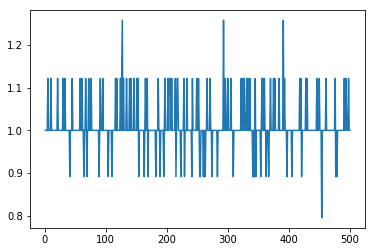

In [42]:
import scipy.stats as sts
import matplotlib.pyplot as plt

A_0_ind = 2
A_0 = A_vec[A_0_ind]
T = 500
A_series = np.zeros(T)
unif_series = sts.uniform.rvs(size=T)
for t_ind in range(T):
    prob_dist = TransMat[A_0_ind, :]
    cum_dist = prob_dist.cumsum()
    unif = unif_series[t_ind]
    A_series[t_ind] = A_vec[(unif < cum_dist).argmax()]

print(A_series)
plt.plot(np.arange(1, T + 1), A_series)
plt.show()